In [1]:
import pandas as pd
import numpy as np

In [2]:
EPTdf = pd.read_csv('data/processed/EPT-14/01_EPT_processed_5splits_Species_DNA.csv')
EPTdf.insert(38, 'Log_Reads', np.log(EPTdf['read count_DNA']))
EPTdf.insert(8, 'Log_Area', np.log(EPTdf['Area']))
EPTdf.insert(7, 'Log_Perimeter', np.log(EPTdf['Perimeter']))
EPTdf.insert(6, 'Log_MaxFeret', np.log(EPTdf['Max Feret Diameter']))
EPTdf.to_csv('data/processed/EPT-14/EPT-14-DL-final_processed_5splits_for_linear.csv', index=False)

EPTmean = EPTdf.groupby('Specimen ID').first()
EPTmean['Area'] = EPTdf.groupby('Specimen ID')['Area'].mean()
EPTmean['Log_Area'] = np.log(EPTmean['Area'])

EPTmean['Perimeter'] = EPTdf.groupby('Specimen ID')['Perimeter'].mean()
EPTmean['Log_Perimeter'] = np.log(EPTmean['Perimeter'])

EPTmean['Max Feret Diameter'] = EPTdf.groupby('Specimen ID')['Max Feret Diameter'].mean()
EPTmean['Log_MaxFeret'] = np.log(EPTmean['Max Feret Diameter'])

EPTmean['Reads'] = EPTdf.groupby('Specimen ID')['read count_DNA'].mean()
EPTmean['Log_Reads'] = np.log(EPTmean['Reads'])

In [3]:
Sets = {'Area+MaxFeret+Perimeter': ["Area", "Max Feret Diameter", "Perimeter"],
        'Area': ["Area"],
        'MaxFeret': ["Max Feret Diameter"],
        'Perimeter': ["Perimeter"],
        'Reads': ["read count_DNA"]
       }

Log_Sets = {'LogArea+LogMaxFeret+LogPerimeter': ["Log_Area", "Log_MaxFeret", "Log_Perimeter"],
        'LogArea': ["Log_Area"],
        'LogMaxFeret': ["Log_MaxFeret"],
        'LogPerimeter': ["Log_Perimeter"],
        'LogReads': ["Log_Reads"]
       }
Log1_Sets = {'1LogArea+LogMaxFeret+LogPerimeter': ["Log_Area", "Log_MaxFeret", "Log_Perimeter"],
        '1LogArea': ["Log_Area"],
        '1LogMaxFeret': ["Log_MaxFeret"],
        '1LogPerimeter': ["Log_Perimeter"],
        '1LogReads': ["Log_Reads"]
       }

TestPairs = {'Log_weights': Log_Sets,
             'Log+1_weights': Log1_Sets,
             'Specimen Weight': Sets
            }

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    nonzero_elements = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100

# Function to calculate Median Absolute Percentage Error (MdAPE)
def median_absolute_percentage_error(y_true, y_pred):
    nonzero_elements = y_true != 0  # Avoid division by zero
    return np.median(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100

# Loop over TestPairs to evaluate each target/predictor set
for target, myset in TestPairs.items():
    for key, value in myset.items():
        # Define features and target variable
        X = EPTmean[value]
        y = EPTmean[target]

        # Store results for each fold
        results = []

        # Cross-validation over 5 folds
        for fold in range(5):
            # Get train, test, and validation indices based on the current fold
            train_idx = EPTmean[EPTmean[str(fold)] == "train"].index
            test_idx = EPTmean[EPTmean[str(fold)] == "test"].index
            val_idx = EPTmean[EPTmean[str(fold)] == "val"].index

            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_test, y_test = X.loc[test_idx], y.loc[test_idx]
            X_val, y_val = X.loc[val_idx], y.loc[val_idx]

            # Initialize and train linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)

            # Store results
            results.append({
                'fold': fold,
                'mse': mse,
                'model': model,
                'train_idx': train_idx,
                'test_idx': test_idx,
                'val_idx': val_idx
            })

        # Lists to store metrics for all folds
        rmse_list = []
        mae_list = []
        mape_list = []
        mdape_list = []
        mse_list = []
        r2_list = []

        # Compute metrics for each fold and store in the lists
        for result in results:
            fold_number = result['fold']
            model = result['model']
            y_test_actual = y.loc[result['test_idx']]
            y_test_pred = model.predict(X.loc[result['test_idx']])

            ## If the values are log-transformed (assumed by column names starting with 'Log')
            #if target.startswith('Log'):
            #    y_test_actual = np.exp(y_test_actual)  # Transform back from log
            #    y_test_pred = np.exp(y_test_pred)      # Transform back from log

            # Calculate metrics on the original scale
            mse = mean_squared_error(y_test_actual, y_test_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test_actual, y_test_pred)
            mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
            mdape = median_absolute_percentage_error(y_test_actual, y_test_pred)
            mae = mean_absolute_error(y_test_actual, y_test_pred)

            # Append metrics to the respective lists
            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)
            mdape_list.append(mdape)
            mse_list.append(mse)
            r2_list.append(r2)

        # Create a DataFrame for fold-wise metrics
        metrics_list = [{'Fold': i, 'RMSE': rmse_list[i], 'MAE': mae_list[i], 'MAPE (%)': mape_list[i],
                         'MdAPE (%)': mdape_list[i], 'MSE': mse_list[i], 'R²': r2_list[i]} for i in range(5)]
        metrics_df = pd.DataFrame(metrics_list).round(3)

        # Print fold-wise metrics
        #print(f'Printing fold-wise metrics for {key}')
        #print(metrics_df)
        #print(' ')

        # Create a summary DataFrame for mean and std of metrics
        metrics_summary = {
            'Metric': ['RMSE', 'MAE', 'MAPE (%)', 'MdAPE (%)', 'MSE', 'R²'],
            'mean': [
                np.mean(rmse_list),
                np.mean(mae_list),
                np.mean(mape_list),
                np.mean(mdape_list),
                np.mean(mse_list),
                np.mean(r2_list)
            ],
            'std': [
                np.std(rmse_list),
                np.std(mae_list),
                np.std(mape_list),
                np.std(mdape_list),
                np.std(mse_list),
                np.std(r2_list)
            ]
        }

        # Convert the summary dictionary to a DataFrame
        metrics_summary_df = pd.DataFrame(metrics_summary).round(3)

        # Transpose the DataFrame for better readability
        metrics_summary_df = metrics_summary_df.set_index('Metric').transpose()

        # Print the summary of metrics
        print(f'{key}')
        print(metrics_summary_df)
        print(' ')


LogArea+LogMaxFeret+LogPerimeter
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    0.723  0.538   228.551     53.355  0.527  0.812
std     0.063  0.039    58.034      6.462  0.086  0.029
 
LogArea
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    1.004  0.804   251.876     82.232  1.010  0.640
std     0.041  0.031    46.950      4.078  0.082  0.028
 
LogMaxFeret
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    1.229  0.946   264.003     87.250  1.514  0.460
std     0.049  0.034    26.774      6.451  0.121  0.031
 
LogPerimeter
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    1.357  1.066   308.539     98.121  1.843  0.343
std     0.046  0.043    37.041      6.292  0.127  0.030
 
LogReads
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    1.666  1.352   573.468    120.001  2.781  0.011
std     0.081  0.067    61.333     23.531  0.266  0.019
 
1LogArea+LogMaxFeret+LogPerimeter
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    nonzero_elements = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100

# Function to calculate Median Absolute Percentage Error (MdAPE)
def median_absolute_percentage_error(y_true, y_pred):
    nonzero_elements = y_true != 0  # Avoid division by zero
    return np.median(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100


all_predictions = []
# Loop over TestPairs to evaluate each target/predictor set
for target, myset in TestPairs.items():
    for key, value in myset.items():
        # Define features and target variable
        X = EPTmean[value]
        y = EPTmean[target]

        # Store results for each fold
        results = []

        # Cross-validation over 5 folds
        for fold in range(5):
            # Get train, test, and validation indices based on the current fold
            train_idx = EPTmean[EPTmean[str(fold)] == "train"].index
            test_idx = EPTmean[EPTmean[str(fold)] == "test"].index
            val_idx = EPTmean[EPTmean[str(fold)] == "val"].index

            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_test, y_test = X.loc[test_idx], y.loc[test_idx]
            X_val, y_val = X.loc[val_idx], y.loc[val_idx]

            # Initialize and train linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)

            # Store results
            results.append({
                'fold': fold,
                'mse': mse,
                'model': model,
                'train_idx': train_idx,
                'test_idx': test_idx,
                'val_idx': val_idx
            })

        # Lists to store metrics for all folds
        rmse_list = []
        mae_list = []
        mape_list = []
        mdape_list = []
        mse_list = []
        r2_list = []

        # Compute metrics for each fold and store in the lists
        for result in results:
            fold_number = result['fold']
            model = result['model']
            y_test_actual = y.loc[result['test_idx']]
            y_test_pred = model.predict(X.loc[result['test_idx']])

            ## If the values are log-transformed (assumed by column names starting with 'Log')
            #if target.startswith('Log'):
            #    y_test_actual = np.exp(y_test_actual)  # Transform back from log
            #    y_test_pred = np.exp(y_test_pred)      # Transform back from log

            # Create a temporary DataFrame for this fold's predictions
            temp_df = pd.DataFrame({
                'actual': y_test_actual,
                'predicted': y_test_pred,
                'fold': fold_number,
                'target': target,
                'key': key
            }, index=y_test_actual.index)

            # Append to the global list
            all_predictions.append(temp_df)    
                
            # Calculate metrics on the original scale
            mse = mean_squared_error(y_test_actual, y_test_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test_actual, y_test_pred)
            mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
            mdape = median_absolute_percentage_error(y_test_actual, y_test_pred)
            mae = mean_absolute_error(y_test_actual, y_test_pred)

            # Append metrics to the respective lists
            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)
            mdape_list.append(mdape)
            mse_list.append(mse)
            r2_list.append(r2)

        # Create a DataFrame for fold-wise metrics
        metrics_list = [{'Fold': i, 'RMSE': rmse_list[i], 'MAE': mae_list[i], 'MAPE (%)': mape_list[i],
                         'MdAPE (%)': mdape_list[i], 'MSE': mse_list[i], 'R²': r2_list[i]} for i in range(5)]
        metrics_df = pd.DataFrame(metrics_list).round(3)

        # Print fold-wise metrics
        #print(f'Printing fold-wise metrics for {key}')
        #print(metrics_df)
        #print(' ')

        # Create a summary DataFrame for mean and std of metrics
        metrics_summary = {
            'Metric': ['RMSE', 'MAE', 'MAPE (%)', 'MdAPE (%)', 'MSE', 'R²'],
            'mean': [
                np.mean(rmse_list),
                np.mean(mae_list),
                np.mean(mape_list),
                np.mean(mdape_list),
                np.mean(mse_list),
                np.mean(r2_list)
            ],
            'std': [
                np.std(rmse_list),
                np.std(mae_list),
                np.std(mape_list),
                np.std(mdape_list),
                np.std(mse_list),
                np.std(r2_list)
            ]
        }

        # Convert the summary dictionary to a DataFrame
        metrics_summary_df = pd.DataFrame(metrics_summary).round(3)

        # Transpose the DataFrame for better readability
        metrics_summary_df = metrics_summary_df.set_index('Metric').transpose()

        # Print the summary of metrics
        print(f'{key}')
        print(metrics_summary_df)
        print(' ')
        
# Combine all predictions into a single DataFrame
predictions_df = pd.concat(all_predictions)


LogArea+LogMaxFeret+LogPerimeter
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    0.723  0.538   228.551     53.355  0.527  0.812
std     0.063  0.039    58.034      6.462  0.086  0.029
 
LogArea
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    1.004  0.804   251.876     82.232  1.010  0.640
std     0.041  0.031    46.950      4.078  0.082  0.028
 
LogMaxFeret
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    1.229  0.946   264.003     87.250  1.514  0.460
std     0.049  0.034    26.774      6.451  0.121  0.031
 
LogPerimeter
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    1.357  1.066   308.539     98.121  1.843  0.343
std     0.046  0.043    37.041      6.292  0.127  0.030
 
LogReads
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
mean    1.666  1.352   573.468    120.001  2.781  0.011
std     0.081  0.067    61.333     23.531  0.266  0.019
 
1LogArea+LogMaxFeret+LogPerimeter
Metric   RMSE    MAE  MAPE (%)  MdAPE (%)

In [6]:
predictions_df.to_csv('outputs/biodiscover/EPT-14-linear/Linear_predictions.csv')

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    nonzero_elements = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100

# Function to calculate Median Absolute Percentage Error (MdAPE)
def median_absolute_percentage_error(y_true, y_pred):
    nonzero_elements = y_true != 0  # Avoid division by zero
    return np.median(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100

# Loop over TestPairs to evaluate each target/predictor set
for target, myset in TestPairs.items():
    for key, value in myset.items():
        # Define features and target variable
        X = EPTmean[value]
        y = EPTmean[target]

        # Store results for each fold
        results = []

        # Cross-validation over 5 folds
        for fold in range(5):
            # Get train, test, and validation indices based on the current fold
            train_idx = EPTmean[EPTmean[str(fold)] == "train"].index
            test_idx = EPTmean[EPTmean[str(fold)] == "test"].index
            val_idx = EPTmean[EPTmean[str(fold)] == "val"].index

            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_test, y_test = X.loc[test_idx], y.loc[test_idx]
            X_val, y_val = X.loc[val_idx], y.loc[val_idx]

            # Initialize and train linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)

            # Store results
            results.append({
                'fold': fold,
                'mse': mse,
                'model': model,
                'train_idx': train_idx,
                'test_idx': test_idx,
                'val_idx': val_idx
            })

        # List to store metrics for all folds
        metrics_list = []

        # Compute metrics for each fold and store in the list
        for result in results:
            fold_number = result['fold']
            model = result['model']
            y_test_actual = y.loc[result['test_idx']]
            y_test_pred = model.predict(X.loc[result['test_idx']])

            # If the values are log-transformed (assumed by column names starting with 'Log')
            if target.startswith('Log'):
                y_test_actual = np.exp(y_test_actual)  # Transform back from log
                y_test_pred = np.exp(y_test_pred)      # Transform back from log

            # Calculate metrics on the original scale
            mse = mean_squared_error(y_test_actual, y_test_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test_actual, y_test_pred)
            mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
            mdape = median_absolute_percentage_error(y_test_actual, y_test_pred)
            mae = mean_absolute_error(y_test_actual, y_test_pred)

            # Store metrics in dictionary
            metrics_list.append({
                'Fold': fold_number,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE (%)': mape,
                'MdAPE (%)': mdape,
                'MSE': mse,
                'R²': r2,
            })

        # Create a DataFrame from the metrics list
        metrics_df = pd.DataFrame(metrics_list).round(3)

        # Display the DataFrame
        print(f'Printing metrics for {key}')
        metrics_df.to_csv(f'outputs/biodiscover/EPT-14-linear/metrics_linear_mean_{key}.csv')
        print(metrics_df)
        print(' ')


Printing metrics for LogArea+LogMaxFeret+LogPerimeter
   Fold    RMSE    MAE  MAPE (%)  MdAPE (%)      MSE     R²
0     0  18.619  7.358    89.395     41.108  346.658  0.701
1     1  18.630  7.520    74.232     39.481  347.089  0.625
2     2  19.260  6.708    81.143     40.355  370.954  0.631
3     3  16.325  6.036    98.165     35.913  266.501  0.727
4     4  16.215  5.991    55.335     35.311  262.912  0.717
 
Printing metrics for LogArea
   Fold    RMSE     MAE  MAPE (%)  MdAPE (%)      MSE     R²
0     0  28.235  10.965   106.783     71.454  797.212  0.312
1     1  26.249  11.142    96.956     68.895  689.001  0.255
2     2  27.124   9.653   104.462     67.001  735.690  0.269
3     3  26.302  10.097   129.215     72.972  691.791  0.291
4     4  25.448   9.636    91.078     68.308  647.586  0.302
 
Printing metrics for LogMaxFeret
   Fold    RMSE     MAE  MAPE (%)  MdAPE (%)       MSE     R²
0     0  32.311  12.363   128.177     79.234  1044.022  0.099
1     1  29.391  12.258   126.

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    # Ensure no division by zero errors
    nonzero_elements = y_true != 0
    return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements]))

# Function to calculate Median Absolute Percentage Error (MdAPE)
def median_absolute_percentage_error(y_true, y_pred):
    # Ensure no division by zero errors
    nonzero_elements = y_true != 0
    return np.median(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements]))

for target, myset in TestPairs.items():
    for key, value in myset.items():
        # Define features and target variable
        X = EPTdf[value]
        y = EPTdf[target]

        # Store results for each fold
        results = []

        # Cross-validation over 5 folds
        for fold in range(5):
            # Get train, test, and validation indices based on the current fold
            train_idx = EPTdf[EPTdf[str(fold)] == "train"].index
            test_idx = EPTdf[EPTdf[str(fold)] == "test"].index
            val_idx = EPTdf[EPTdf[str(fold)] == "val"].index

            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_test, y_test = X.loc[test_idx], y.loc[test_idx]
            X_val, y_val = X.loc[val_idx], y.loc[val_idx]

            # Initialize and train linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)

            # Store results
            results.append({
                'fold': fold,
                'mse': mse,
                'model': model,
                'train_idx': train_idx,
                'test_idx': test_idx,
                'val_idx': val_idx
            })


        # List to store metrics for all folds
        metrics_list = []

        # Compute metrics for each fold and store in the list
        for result in results:
            fold_number = result['fold']
            model = result['model']
            y_test_actual = y.loc[result['test_idx']]
            y_test_pred = model.predict(X.loc[result['test_idx']])

            # Calculate metrics
            mse = mean_squared_error(y_test_actual, y_test_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test_actual, y_test_pred)
            mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
            mdape = median_absolute_percentage_error(y_test_actual, y_test_pred)
            mae = mean_absolute_error(y_test_actual, y_test_pred)

            # Store metrics in dictionary
            metrics_list.append({
                'Fold': fold_number,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE (%)': mape,
                'MdAPE (%)': mdape,
                'MSE': mse,
                'R²': r2,
            })

        # Create a DataFrame from the metrics list
        metrics_df = pd.DataFrame(metrics_list).round(3)

        # Display the DataFrame
        print(f'Printing metrics for {key}')
        metrics_df.to_csv(f'outputs/biodiscover/EPT-14-linear/metrics_linear_{key}.csv')
        print(pd.DataFrame(metrics_df))
        print(' ')

Printing metrics for LogArea+LogMaxFeret+LogPerimeter
   Fold   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
0     0  0.850  0.603     2.791      0.977  0.722  0.503
1     1  0.797  0.533     2.711      0.943  0.636  0.536
2     2  0.821  0.570     4.243      1.130  0.674  0.478
3     3  0.937  0.643     2.474      0.934  0.879  0.542
4     4  0.640  0.460     1.879      0.799  0.410  0.643
 
Printing metrics for LogArea
   Fold   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
0     0  0.912  0.628     2.571      0.892  0.832  0.427
1     1  0.868  0.556     2.357      0.947  0.753  0.451
2     2  0.874  0.591     3.959      0.967  0.764  0.409
3     3  1.022  0.710     2.610      0.982  1.044  0.456
4     4  0.760  0.543     2.107      0.872  0.578  0.497
 
Printing metrics for LogMaxFeret
   Fold   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
0     0  0.985  0.673     2.655      0.961  0.971  0.332
1     1  0.965  0.619     2.670      1.063  0.931  0.321
2     2  0.959  0.658    

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    # Ensure no division by zero errors
    nonzero_elements = y_true != 0
    return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements]))

# Function to calculate Median Absolute Percentage Error (MdAPE)
def median_absolute_percentage_error(y_true, y_pred):
    # Ensure no division by zero errors
    nonzero_elements = y_true != 0
    return np.median(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements]))

for target, myset in TestPairs.items():
    for key, value in myset.items():
        # Define features and target variable
        X = EPTmean[value]
        y = EPTmean[target]

        # Store results for each fold
        results = []

        # Cross-validation over 5 folds
        for fold in range(5):
            # Get train, test, and validation indices based on the current fold
            train_idx = EPTmean[EPTmean[str(fold)] == "train"].index
            test_idx = EPTmean[EPTmean[str(fold)] == "test"].index
            val_idx = EPTmean[EPTmean[str(fold)] == "val"].index

            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_test, y_test = X.loc[test_idx], y.loc[test_idx]
            X_val, y_val = X.loc[val_idx], y.loc[val_idx]

            # Initialize and train linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)

            # Store results
            results.append({
                'fold': fold,
                'mse': mse,
                'model': model,
                'train_idx': train_idx,
                'test_idx': test_idx,
                'val_idx': val_idx
            })


        # List to store metrics for all folds
        metrics_list = []

        # Compute metrics for each fold and store in the list
        for result in results:
            fold_number = result['fold']
            model = result['model']
            y_test_actual = y.loc[result['test_idx']]
            y_test_pred = model.predict(X.loc[result['test_idx']])

            # Calculate metrics
            mse = mean_squared_error(y_test_actual, y_test_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test_actual, y_test_pred)
            mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)
            mdape = median_absolute_percentage_error(y_test_actual, y_test_pred)
            mae = mean_absolute_error(y_test_actual, y_test_pred)

            # Store metrics in dictionary
            metrics_list.append({
                'Fold': fold_number,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE (%)': mape,
                'MdAPE (%)': mdape,
                'MSE': mse,
                'R²': r2,
            })

        # Create a DataFrame from the metrics list
        metrics_df = pd.DataFrame(metrics_list).round(3)

        # Display the DataFrame
        print(f'Printing metrics for {key}')
        metrics_df.to_csv(f'outputs/biodiscover/EPT-14-linear/metrics_linear_mean_{key}.csv')
        print(pd.DataFrame(metrics_df))
        print(' ')

Printing metrics for LogArea+LogMaxFeret+LogPerimeter
   Fold   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
0     0  0.784  0.590     2.508      0.545  0.615  0.787
1     1  0.732  0.546     2.482      0.606  0.536  0.814
2     2  0.732  0.534     3.065      0.425  0.536  0.781
3     3  0.762  0.551     2.056      0.587  0.581  0.817
4     4  0.604  0.470     1.318      0.505  0.364  0.862
 
Printing metrics for LogArea
   Fold   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
0     0  1.015  0.817     2.526      0.893  1.031  0.643
1     1  1.002  0.781     1.940      0.793  1.004  0.652
2     2  1.007  0.793     3.339      0.786  1.014  0.586
3     3  1.062  0.858     2.573      0.844  1.127  0.646
4     4  0.933  0.770     2.217      0.796  0.871  0.671
 
Printing metrics for LogMaxFeret
   Fold   RMSE    MAE  MAPE (%)  MdAPE (%)    MSE     R²
0     0  1.214  0.942     2.601      0.828  1.473  0.490
1     1  1.243  0.940     2.312      0.955  1.545  0.464
2     2  1.210  0.918    

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    # Ensure no division by zero errors
    nonzero_elements = y_true != 0
    return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements]))

# Function to calculate Median Absolute Percentage Error (MdAPE)
def median_absolute_percentage_error(y_true, y_pred):
    # Ensure no division by zero errors
    nonzero_elements = y_true != 0
    return np.median(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements]))

Best_Sets = {'Area+MaxFeret+Perimeter': ["Area", "Max Feret Diameter", "Perimeter"],
        'Area': ["Area"]}

for key, value in Best_Sets.items():
    # Define features and target variable
    X = EPTmean[value]
    y = EPTmean['Log_weights']

    # Store results for each fold
    results = []

    # Cross-validation over 5 folds
    for fold in range(5):
        # Get train, test, and validation indices based on the current fold
        train_idx = EPTmean[EPTmean[str(fold)] == "train"].index
        test_idx = EPTmean[EPTmean[str(fold)] == "test"].index
        val_idx = EPTmean[EPTmean[str(fold)] == "val"].index

        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_test, y_test = X.loc[test_idx], y.loc[test_idx]
        X_val, y_val = X.loc[val_idx], y.loc[val_idx]

        # Initialize and train linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)

        # Store results
        results.append({
            'fold': fold,
            'mse': mse,
            'model': model,
            'train_idx': train_idx,
            'test_idx': test_idx,
            'val_idx': val_idx
        })


    # Lists to store metrics for all folds
    mse_list = []
    rmse_list = []
    r2_list = []
    mape_list = []
    mdape_list = []
    mae_list = []

    # Compute metrics for each fold and store in lists
    for result in results:
        model = result['model']
        y_test_actual = y.loc[result['test_idx']]
        y_test_pred = model.predict(X.loc[result['test_idx']])

        # Inverse transform the log-transformed data back to original scale
        y_test_actual_exp = np.exp(y_test_actual)
        y_test_pred_exp = np.exp(y_test_pred)

        # Calculate metrics on the original scale
        mse = mean_squared_error(y_test_actual_exp, y_test_pred_exp)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_actual_exp, y_test_pred_exp)
        mape = mean_absolute_percentage_error(y_test_actual_exp, y_test_pred_exp)
        mdape = median_absolute_percentage_error(y_test_actual_exp, y_test_pred_exp)
        mae = mean_absolute_error(y_test_actual_exp, y_test_pred_exp)

        # Append metrics to lists
        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)
        mape_list.append(mape)
        mdape_list.append(mdape)
        mae_list.append(mae)


    # Create a summary DataFrame
    metrics_summary = {
        'Metric': ['RMSE', 'MAE', 'MAPE (%)', 'MdAPE (%)', 'MSE', 'R²'],
        'mean': [
                np.mean(rmse_list),
                np.mean(mae_list),
                np.mean(mape_list),
                np.mean(mdape_list),
                np.mean(mse_list),
                np.mean(r2_list)
            ],
        'std': [
                np.std(rmse_list),
                np.std(mae_list),
                np.std(mape_list),
                np.std(mdape_list),
                np.std(mse_list),
                np.std(r2_list)
            ]
    }

    # Convert the summary dictionary to a DataFrame
    metrics_df = pd.DataFrame(metrics_summary).round(3)
    metrics_df = metrics_df.set_index('Metric').transpose()


    # Display the DataFrame
    print(f'Printing metrics for {key}')
    print(pd.DataFrame(metrics_df))
    print(' ')

Printing metrics for Area+MaxFeret+Perimeter
Metric    RMSE     MAE  MAPE (%)  MdAPE (%)       MSE     R²
mean    32.630  10.690     1.063      0.387  1115.581 -0.084
std      7.133   1.417     0.240      0.025   512.738  0.389
 
Printing metrics for Area
Metric    RMSE    MAE  MAPE (%)  MdAPE (%)      MSE     R²
mean    23.271  8.688     1.024      0.351  549.862  0.453
std      2.886  1.216     0.220      0.021  131.762  0.112
 


In [11]:
y_test_actual[y_test_actual > 4]

Specimen ID
1_B6     5.005154
3_F5     4.647655
4_G3     4.666265
5_B9     4.123094
6_E6     5.046067
7_D11    4.394202
7_F3     4.775166
7_F5     4.759521
8_E10    5.051457
9_A4     4.491777
9_D2     4.708358
Name: Log_weights, dtype: float64

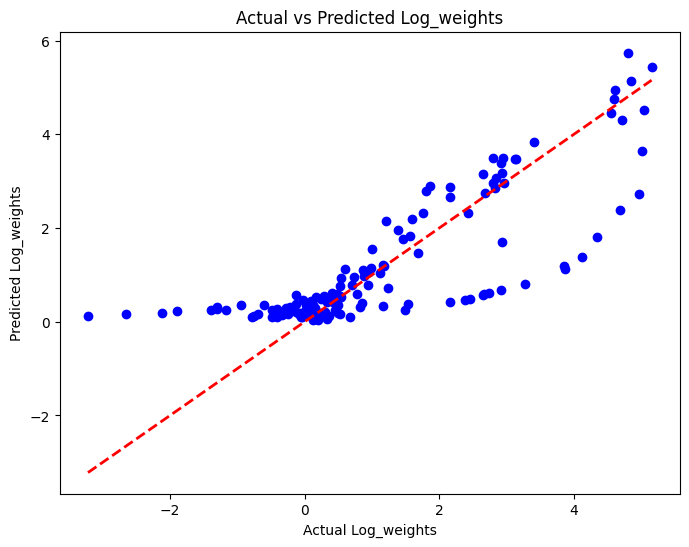

In [12]:
import matplotlib.pyplot as plt

# Select the first fold results for demonstration
fold_result = results[0] 

# Get actual and predicted values
y_test_actual = y.loc[fold_result['test_idx']]
y_test_pred = fold_result['model'].predict(X.loc[fold_result['test_idx']])

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_test_pred, color="blue")
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel("Actual Log_weights")
plt.ylabel("Predicted Log_weights")
plt.title("Actual vs Predicted Log_weights")
plt.show()


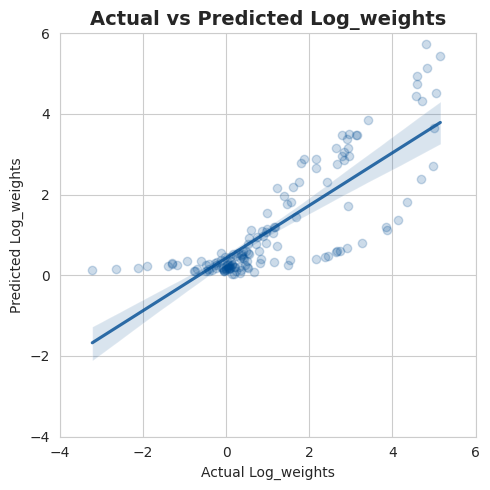

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Assuming y_test_actual and y_test_pred are already defined

# Set up the figure for a single plot
plt.figure(figsize=(5, 5))

custom_color = '#004C93'  # Custom color for the scatter and line

# Create a scatter plot with a regression line
sns.regplot(x=y_test_actual, y=y_test_pred, 
            color=custom_color, 
            line_kws={"color": custom_color, "alpha": 0.8},  # Slightly transparent regression line
            scatter_kws={"color": custom_color, "alpha": 0.2})  # Slightly transparent points

# Plot a reference line for perfect prediction (y = x line)
#plt.plot([y_test_actual.min(), y_test_actual.max()], 
#         [y_test_actual.min(), y_test_actual.max()], 
#         'r--', lw=2)  # Red dashed line for reference

plt.xlim(-4, 6)
plt.ylim(-4, 6)

# Customize the labels and title
plt.xlabel("Actual Log_weights")
plt.ylabel("Predicted Log_weights")
plt.title("Actual vs Predicted Log_weights", fontsize=14, weight='bold')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('EPT-14-linear-baseline.svg')

# Show the plot
plt.show()


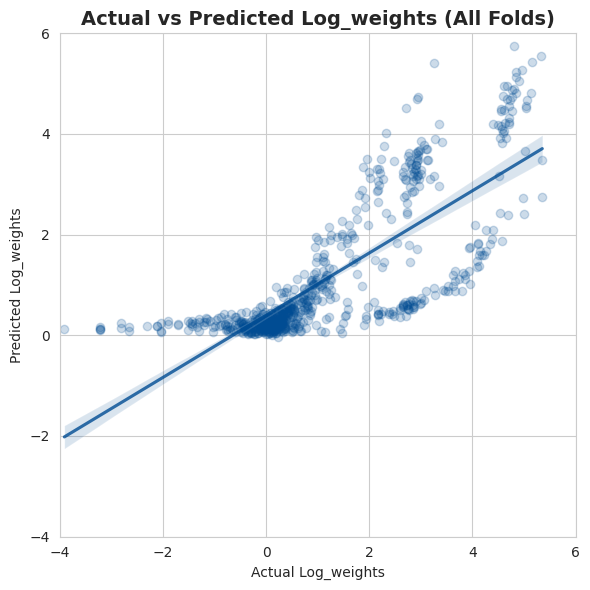

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style for the plot
sns.set_style('whitegrid')

# Initialize lists to store all actual and predicted values from all folds
all_y_test_actual = []
all_y_test_pred = []

# Loop through all fold results in the 'results' list
for fold_result in results:
    # Get actual and predicted values for the current fold
    y_test_actual = y.loc[fold_result['test_idx']]
    y_test_pred = fold_result['model'].predict(X.loc[fold_result['test_idx']])
    
    # Append values to the lists
    all_y_test_actual.extend(y_test_actual)
    all_y_test_pred.extend(y_test_pred)

# Convert lists to numpy arrays for easier plotting
all_y_test_actual = np.array(all_y_test_actual)
all_y_test_pred = np.array(all_y_test_pred)

# Set up the figure for a single plot
plt.figure(figsize=(6, 6))

custom_color = '#004C93'  # Custom color for the scatter and line

# Create a scatter plot with a regression line for all combined data
sns.regplot(x=all_y_test_actual, y=all_y_test_pred, 
            color=custom_color, 
            line_kws={"color": custom_color, "alpha": 0.8},  # Slightly transparent regression line
            scatter_kws={"color": custom_color, "alpha": 0.2})  # Slightly transparent points

# Set limits for the x and y axes
plt.xlim(-4, 6)
plt.ylim(-4, 6)

# Customize the labels and title
plt.xlabel("Actual Log_weights")
plt.ylabel("Predicted Log_weights")
plt.title("Actual vs Predicted Log_weights (All Folds)", fontsize=14, weight='bold')

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file (optional)
plt.savefig('EPT-allfolds-linear-baseline.svg')

# Show the plot
plt.show()


In [15]:
len(all_y_test_actual)

743

In [16]:
len(all_y_test_pred)

743

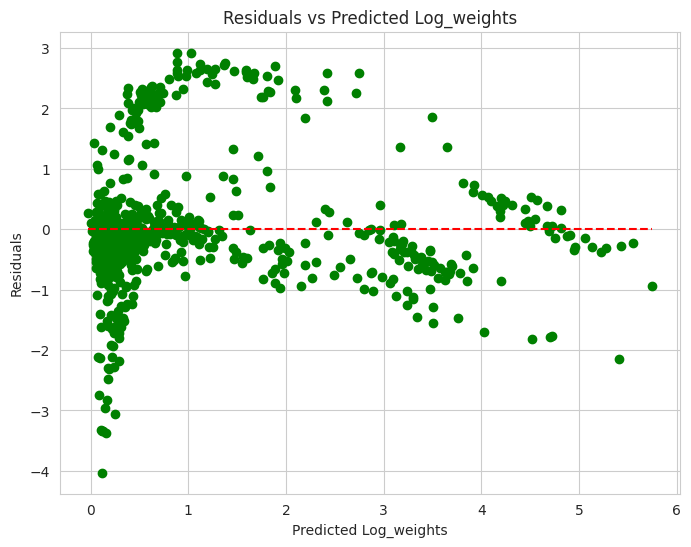

In [17]:
# Residuals
residuals = all_y_test_actual - all_y_test_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(all_y_test_pred, residuals, color="green")
plt.hlines(0, all_y_test_pred.min(), all_y_test_pred.max(), colors='r', linestyles='dashed')
plt.xlabel("Predicted Log_weights")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Log_weights")
plt.show()
